# Data Overview

### Arrhythmia Dataset
- Number of Samples: 109446
- Number of Categories: 5
- Sampling Frequency: 125Hz
- Data Source: Physionet's MIT-BIH Arrhythmia Dataset
- Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

### Note
- This dataset consists of a series of CSV files.
- Each of these CSV files contain a matrix, with each row representing an example in that portion of the dataset.
- The final element of each row denotes the class to which that example belongs.

|Category|Annotations|
|--|--|
|N|1. Normal|
||2. Left/Right bundle branch block|
||3. Atrial escape|
||4. Nodal escape|
| | |
|S|1. Atrial premature|
||2. Aberrant atrial premature
||3. Nodal premature
||4. Supra-ventricular premature|
| | |
|V|1. Premature ventricular contraction|
||2. Ventricular escape|
|F|1. Fusion of ventricular and normal|
| | |
|Q|1. Paced|
||2. Fusion of paced and normal|
||3. Unclassifiable|

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Utility Functions

In [3]:
# Function to plot loss, accuracy and best epoch

def learning_curves_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)
        
    index_loss = np.argmin(vloss)  # this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    
    plt.style.use('fivethirtyeight')
    
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# Load & Explore Data

In [4]:
# Load dataset
train_data = pd.read_csv('Heartbeat_Dataset/mitbih_train.csv')
test_data = pd.read_csv('Heartbeat_Dataset/mitbih_test.csv')

In [5]:
print(f"Number of samples in train data: {train_data.shape[0]}")
print(f"Number of samples in test data: {test_data.shape[0]}")

Number of samples in train data: 87553
Number of samples in test data: 21891


In [6]:
# Explore the dataset
train_data.head()

,9.779411554336547852e-01,9.264705777168273926e-01,6.813725233078002930e-01,2.450980395078659058e-01,1.544117629528045654e-01,1.911764740943908691e-01,1.519607901573181152e-01,8.578431606292724609e-02,5.882352963089942932e-02,4.901960864663124084e-02,...,0.000000000000000000e+00.79,0.000000000000000000e+00.80,0.000000000000000000e+00.81,0.000000000000000000e+00.82,0.000000000000000000e+00.83,0.000000000000000000e+00.84,0.000000000000000000e+00.85,0.000000000000000000e+00.86,0.000000000000000000e+00.87,0.000000000000000000e+00.88
0,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
print(f"Missing values in train data: {train_data.isna().sum().sum()}")
print(f"Missing values in test data: {test_data.isna().sum().sum()}")

Missing values in train data: 0
Missing values in test data: 0


In [8]:
print(f"Duplicated values in train data: {train_data.duplicated().sum()}")
print(f"Duplicated values in test data: {test_data.duplicated().sum()}")

Duplicated values in train data: 0
Duplicated values in test data: 0


In [9]:
print(train_data.iloc[:, -1].value_counts())  # Check class distribution in train data

0.000000000000000000e+00.88
0.0    72470
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


In [10]:
print(test_data.iloc[:, -1].value_counts())  # Check class distribution in test data

0.000000000000000000e+00.65
0.0    18117
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64


In [11]:
test_classes = test_data.iloc[:, -1].unique()
train_classes = train_data.iloc[:, -1].unique()

In [12]:
print(test_classes)
print(train_classes)

[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]


In [17]:
labels = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}

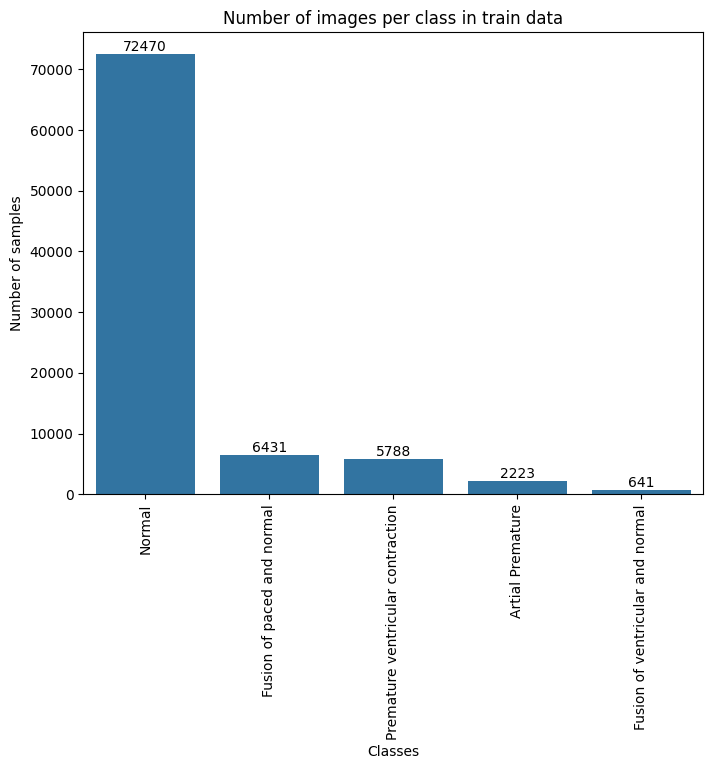

In [18]:
train_counts = train_data.iloc[:,-1].value_counts().rename(labels)

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=train_counts.index, y=train_counts.values)

# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    ax.annotate(f'{train_counts[i]}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=10)

plt.title('Number of images per class in train data')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.xticks(rotation=90)
plt.show()

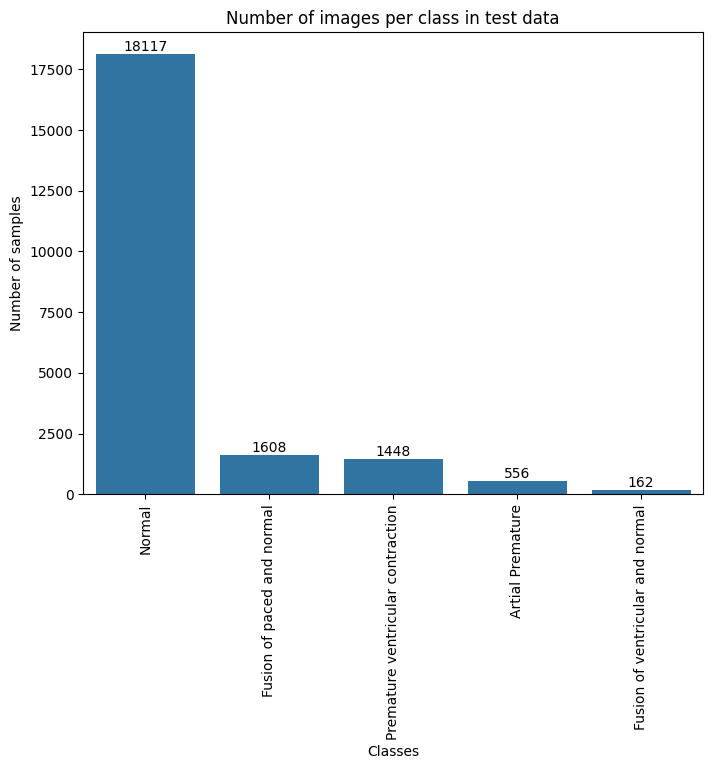

In [19]:
test_counts = test_data.iloc[:,-1].value_counts().rename(labels)

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=test_counts.index, y=test_counts.values)

# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    ax.annotate(f'{test_counts[i]}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=10)

plt.title('Number of images per class in test data')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.xticks(rotation=90)
plt.show()

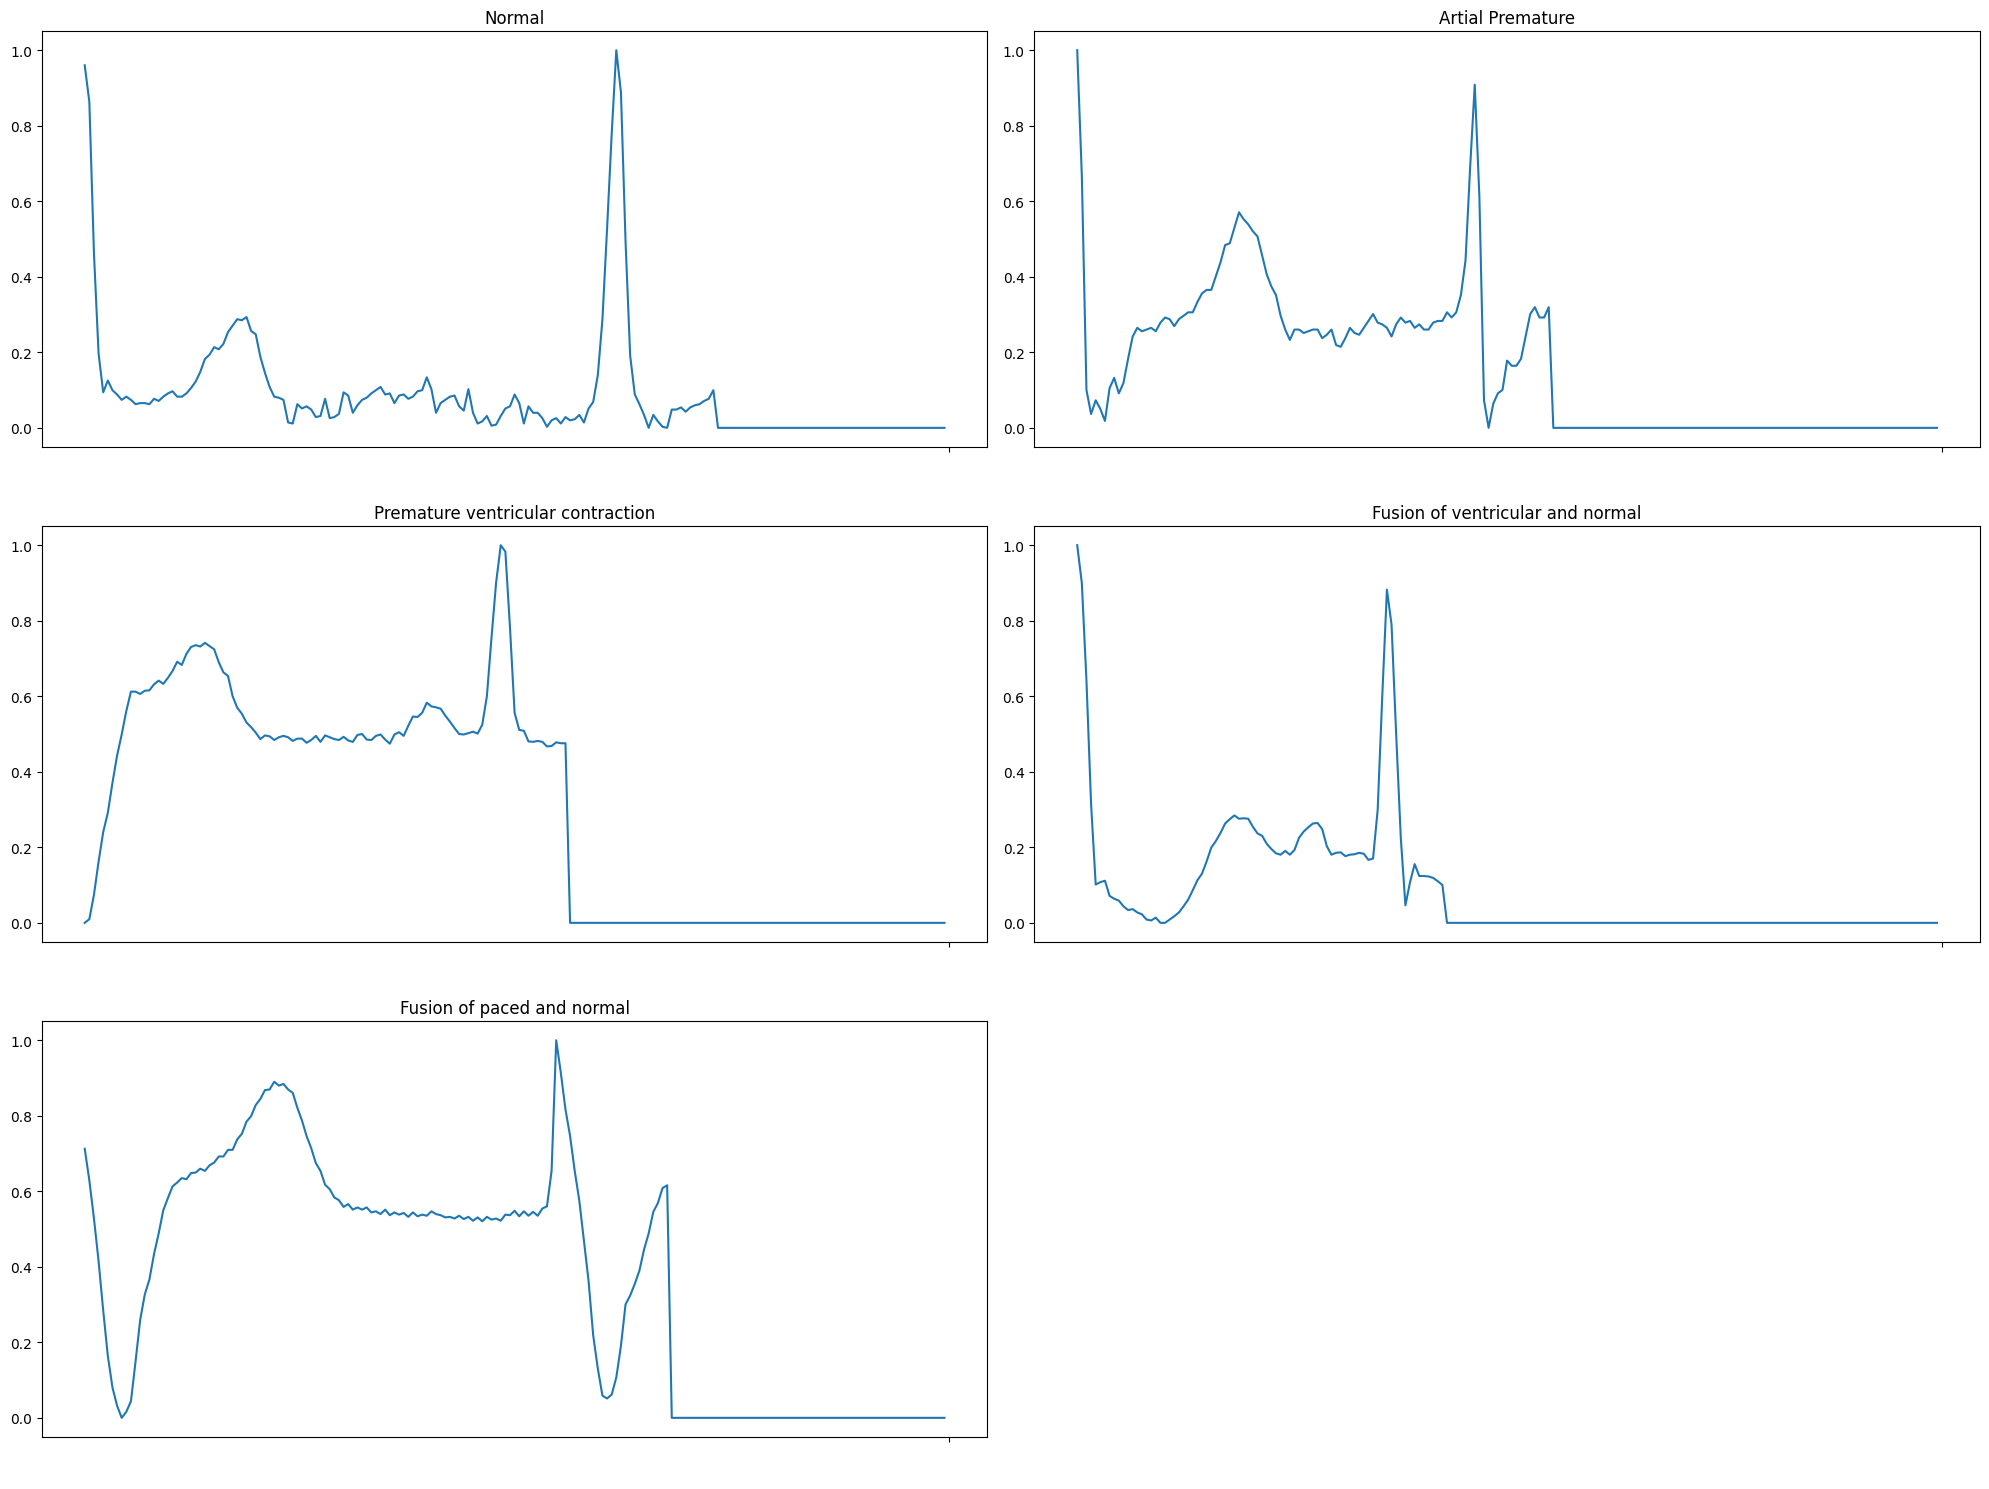

In [20]:
# Plot each class
train_classes = train_data.iloc[:, -1].unique()

plt.figure(figsize=(20, 15))

for i, cls in enumerate(train_classes):
    plt.subplot(3, 2, i + 1)
    plt.plot(train_data[train_data.iloc[:, -1] == cls].iloc[0, :-1])  # Exclude the label column
    plt.title(f'{list(labels.values())[i]}')
    plt.xlabel(" ")
    plt.xticks(ticks=" ",labels =" ",rotation=45)

plt.tight_layout()
plt.show()

# Data Preprocessing

In [13]:
# Separate features and labels
X_train = train_data.iloc[:, :-1].values  # Exclude label
y_train = train_data.iloc[:, -1].values   # Labels

X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

# Scailing the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the number of samples for the validation set based on the test data size
n_test_samples = X_test_scaled.shape[0]

# Split the training data into new training and validation sets
X_val, X_test_new, y_val, y_test_new = train_test_split(X_test_scaled, y_test, test_size=0.5, random_state=42, stratify=y_test)

# Reshape the data for RNN/LSTM/GRU (samples, timesteps, features)
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test_new = np.reshape(X_test_new, (X_test_new.shape[0], X_test_new.shape[1], 1))


print(f"New Training set size: {X_train_scaled.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test_new.shape}")

New Training set size: (87553, 187, 1)
Validation set size: (10945, 187, 1)
Test set size: (10946, 187, 1)


# RNN

In [22]:
def build_rnn_model():
    model = Sequential()
    model.add(SimpleRNN(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(64))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    
    return model

In [23]:
rnn_model = build_rnn_model()

In [24]:
rnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=6,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              verbose=1,
                              patience=2,
                              min_lr=1e-6)

model_checkpoint = ModelCheckpoint('model.keras',
                                   monitor='val_loss',
                                   save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [26]:
rnn_history = rnn_model.fit(X_train_scaled, y_train,
                            epochs=10,
                            batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks= callbacks)

Epoch 1/10
2425/2737 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8216 - loss: 0.7124

KeyboardInterrupt: 

In [ ]:
learning_curves_plot(rnn_history, start_epoch=0)

In [ ]:
# Predict on the test set
y_test_pred_rnn = rnn_model.predict(X_test_new).argmax(axis=1)

In [ ]:
# Evaluate RNN Model on Test Data
rnn_test_loss, rnn_test_acc = rnn_model.evaluate(X_test_new, y_test_new, verbose=0)
print(f"RNN Test Loss: {rnn_test_loss:.4f}")
print(f"RNN Test Accuracy: {rnn_test_acc:.4f}")

In [ ]:
# Classification report for RNN
print("RNN Classification Report:")
print(classification_report(y_test_new, y_test_pred_rnn))

In [ ]:
class_names = [labels[i] for i in range(len(labels))]

In [ ]:
# Confusion Matrix for RNN
conf_matrix_rnn = confusion_matrix(y_test_new, y_test_pred_rnn)

plot_confusion_matrix(conf_matrix_rnn, 
                      class_names=class_names, 
                      show_normed=True,
                      figsize=(8,6),
                      colorbar=True)

plt.title('RNN Confusion Matrix')
plt.show()

# GRU

In [ ]:
def build_gru_model():
    model = Sequential()
    model.add(GRU(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(64))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    
    return model

In [ ]:
gru_model = build_gru_model()

In [ ]:
gru_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
gru_history = gru_model.fit(X_train_scaled, y_train,
                            epochs=20,
                            batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks= callbacks)

In [ ]:
learning_curves_plot(gru_history, start_epoch=0)

In [ ]:
y_test_pred_gru = gru_model.predict(X_test_new).argmax(axis=1)

In [ ]:
# Evaluate GRU Model on Test Data
gru_test_loss, gru_test_acc = gru_model.evaluate(X_test_new, y_test_new, verbose=0)
print(f"GRU Test Loss: {gru_test_loss:.4f}")
print(f"GRU Test Accuracy: {gru_test_acc:.4f}")

In [ ]:
# GRU classification report
print("GRU Classification Report:")
print(classification_report(y_test_new, y_test_pred_gru))

In [ ]:
# Confusion matrix for GRU
conf_matrix_gru = confusion_matrix(y_test_new, y_test_pred_gru)

plot_confusion_matrix(conf_matrix_gru, 
                      class_names=class_names, 
                      show_normed=True,
                      figsize=(8,6),
                      colorbar=True)

plt.title('GRU Confusion Matrix')
plt.show()

# LSTM

In [ ]:
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    
    return model

In [ ]:
lstm_model = build_lstm_model()

In [ ]:
lstm_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
lstm_history = lstm_model.fit(X_train_scaled, y_train,
                            epochs=20,
                            batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks= [reduce_lr, model_checkpoint])

In [ ]:
learning_curves_plot(lstm_history, start_epoch=0)

In [ ]:
y_test_pred_lstm = lstm_model.predict(X_test_new).argmax(axis=1)

In [ ]:
# Evaluate LSTM Model on Test Data
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test_new, y_test_new, verbose=0)
print(f"LSTM Test Loss: {lstm_test_loss:.4f}")
print(f"LSTM Test Accuracy: {lstm_test_acc:.4f}")

In [ ]:
# LSTM classification report
print("LSTM Classification Report:")
print(classification_report(y_test_new, y_test_pred_lstm))

In [ ]:
# Confusion matrix for LSTM
conf_matrix_lstm = confusion_matrix(y_test_new, y_test_pred_lstm)

plot_confusion_matrix(conf_matrix_lstm, 
                      class_names=class_names, 
                      show_normed=True,
                      figsize=(8,6),
                      colorbar=True)

plt.title('LSTM Confusion Matrix')
plt.show()

# Thank you